# Parameter estimation and hypothesis testing

In [1]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
from ipywidgets import interact
import arviz as az
%matplotlib inline
sns.set()

## Learning Objectives of Part 2

1. Understand what priors, likelihoods and posteriors are;
2. Use random sampling for parameter estimation to appreciate the relationship between sample size & the posterior distribution, along with the effect of the prior;
3. Use probabilistic programming for parameter estimation;
4. Use probabilistic programming for hypothesis testing.

## 1. From Bayes Theorem to Bayesian Inference

Let's say that we flip a biased coin several times and we want to estimate the probability of heads from the number of heads we saw. Statistical intuition tells us that our best estimate of $p(heads)=$ number of heads divided by total number of flips.

However, 

1. It doesn't tell us how certain we can be of that estimate and
2. This type of intuition doesn't extend to even slightly more complex examples.

Bayesian inference helps us here. We can calculate the probability of a particular $p=p(H)$ given data $D$ by setting $A$ in Bayes Theorem equal to $p$ and $B$ equal to $D$.


$$P(p|D) = \frac{P(D|p)P(p)}{P(D)} $$



In this equation, we call $P(p)$ the prior (distribution), $P(D|p)$ the likelihood and $P(p|D)$ the posterior (distribution). The intuition behind the nomenclature is as follows: the prior is the distribution containing our knowledge about $p$ prior to the introduction of the data $D$ & the posterior is the distribution containing our knowledge about $p$ after considering the data $D$.

**Note** that we're _overloading_ the term _probability_ here. In fact, we have 3 distinct usages of the word:
- The probability $p$ of seeing a head when flipping a coin;
- The resulting binomial probability distribution $P(D|p)$ of seeing the data $D$, given $p$;
- The prior & posterior probability distributions of $p$, encoding our _uncertainty_ about the value of $p$.

**Key concept:** We only need to know the posterior distribution $P(p|D)$ up to multiplication by a constant at the moment: this is because we really only care about the values of $P(p|D)$ relative to each other – for example, what is the most likely value of $p$? To answer such questions, we only need to know what $P(p|D)$ is proportional to, as a function of $p$. Thus we don’t currently need to worry about the term $P(D)$. In fact,

$$P(p|D) \propto P(D|p)P(p) $$

**Note:** What is the prior? Really, what do we know about $p$ before we see any data? Well, as it is a probability, we know that $0\leq p \leq1$. If we haven’t flipped any coins yet, we don’t know much else: so it seems logical that all values of $p$ within this interval are equally likely, i.e., $P(p)=1$, for $0\leq p \leq1$. This is known as an uninformative prior because it contains little information (there are other uninformative priors we may use in this situation, such as the Jeffreys prior, to be discussed later). People who like to hate on Bayesian inference tend to claim that the need to choose a prior makes Bayesian methods somewhat arbitrary, but as we’ll now see, if you have enough data, the likelihood dominates over the prior and the latter doesn’t matter so much.


**Essential remark:** we get the whole distribution of $P(p|D)$, not merely a point estimate plus errors bars, such as [95% confidence intervals](http://andrewgelman.com/2018/07/04/4th-july-lets-declare-independence-95/).


## 2. Bayesian parameter estimation I: flip those coins

Now let's generate some coin flips and try to estimate $p(H)$. Two notes:
- given data $D$ consisting of $n$ coin tosses & $k$ heads, the likelihood function is given by $L:=P(D|p) \propto p^k(1-p)^{n-k}$;
- given a uniform prior, the posterior is proportional to the likelihood.

In [2]:
def plot_posterior(p=0.6, N=0):
    """Plot the posterior given a uniform prior; Bernoulli trials
    with probability p; sample size N"""
    rng = np.random.default_rng(42)
    # Flip coins 
    n_successes = rng.binomial(N, p)
    # X-axis for PDF
    x = np.linspace(0, 1, 100)
    # Prior
    prior = 1
    # Compute posterior, given the likelihood (analytic form)
    posterior = x**n_successes*(1-x)**(N-n_successes)*prior
    posterior /= np.max(posterior)  # so that peak always at 1
    plt.plot(x, posterior)
    plt.show()

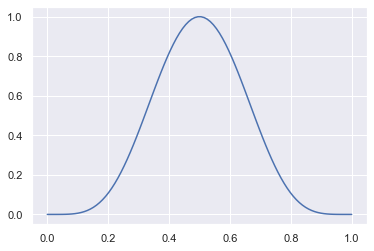

In [3]:
plot_posterior(N=10)

* Now use the great ipywidget interact to check out the posterior as you generate more and more data (you can also vary $p$):

In [4]:
interact(plot_posterior, p=(0, 1, 0.01), N=(0, 1500));

interactive(children=(FloatSlider(value=0.6, description='p', max=1.0, step=0.01), IntSlider(value=0, descript…

**Notes for discussion:**

* as you generate more and more data, your posterior gets narrower, i.e. you get more and more certain of your estimate.
* you need more data to be certain of your estimate when $p=0.5$, as opposed to when $p=0$ or $p=1$. 

### The choice of the prior

You may have noticed that we needed to choose a prior and that, in the small to medium data limit, this choice can affect the posterior. We'll briefly introduce several types of priors and then you'll use one of them for the example above to see the effect of the prior:

- **Informative priors** express specific, definite information about a variable, for example, if we got a coin from the mint, we may use an informative prior with a peak at $p=0.5$ and small variance. 
- **Weakly informative priors** express partial information about a variable, such as a peak at $p=0.5$ (if we have no reason to believe the coin is biased), with a larger variance.
- **Uninformative priors** express no information about a variable, except what we know for sure, such as knowing that $0\leq p \leq1$.

Now you may think that the _uniform distribution_ is uninformative, however, what if I am thinking about this question in terms of the probability $p$ and Eric Ma is thinking about it in terms of the _odds ratio_ $r=\frac{p}{1-p}$? Eric rightly feels that he has no prior knowledge as to what this $r$ is and thus chooses the uniform prior on $r$.

With a bit of algebra (transformation of variables), we can show that choosing the uniform prior on $p$ amounts to choosing a decidedly non-uniform prior on $r$ and vice versa. So Eric and I have actually chosen different priors, using the same philosophy. How do we avoid this happening? Enter the **Jeffreys prior**, which is an uninformative prior that solves this problem. You can read more about the Jeffreys prior [here](https://en.wikipedia.org/wiki/Jeffreys_prior) & in your favourite Bayesian text book (Sivia gives a nice treatment). 

In the binomial (coin flip) case, the Jeffreys prior is given by $P(p) = \frac{1}{\sqrt{p(1-p)}}$.



#### Hands-on

* Create an interactive plot like the one above, except that it has two posteriors on it: one for the uniform prior, another for the Jeffries prior.

In [5]:
# Solution
def plot_posteriors(p=0.6, N=0):
    rng = np.random.default_rng(42)
    n_successes = rng.binomial(N, p)
    x = np.linspace(0.01, 0.99, 100)
    posterior1 = x**n_successes*(1-x)**(N-n_successes)  # w/ uniform prior
    posterior1 /= np.max(posterior1)  # so that peak always at 1
    plt.plot(x, posterior1, label='Uniform prior')
    jp = np.sqrt(x*(1-x))**(-1)  # Jeffreys prior
    posterior2 = posterior1*jp  # w/ Jeffreys prior
    posterior2 /= np.max(posterior2)  # so that peak always at 1 (not quite correct to do; see below)
    plt.plot(x, posterior2, label='Jeffreys prior')
    plt.legend()
    plt.show()

In [6]:
interact(plot_posteriors, p=(0, 1, 0.01), N=(0, 100));

interactive(children=(FloatSlider(value=0.6, description='p', max=1.0, step=0.01), IntSlider(value=0, descript…

**Question:** What happens to the posteriors as you generate more and more data?

# The Bayesian Workflow OR A Taste of Probabilistic Programming

## Bayesian parameter estimation using PyMC

Now it's time to generalize our new skills and build on them by learning the basics of probabilistic programming using PyMC. To this end, let's recap the general workflow. 

In the basics of Bayesian model building, the steps are
1. To completely specify the model in terms of _probability distributions_. This includes specifying 
    - what the form of the sampling distribution of the data is _and_ 
    - what form describes our _uncertainty_ in the unknown parameters.
2. Calculate the _posterior distribution_.

In Chapter 5 and 6's biased coin flipping example, the form of the sampling distribution of the data was Binomial (described by the likelihood) and the uncertainty around the unknown parameter $p$ captured by the prior (we used both the uniform and the Jeffreys priors).

Now it is time to do the same using the **probabilistic programming language** PyMC. There's _loads of cool stuff_ about PyMC and this paradigm, two of which are
- _probabililty distributions_ are first class citizens, in that we can assign them to variables and use them intuitively to mirror how we think about priors, likelihoods & posteriors.
- PyMC calculates the posterior for us!

Under the hood, PyMC will compute the posterior using a sampling based approach called Markov Chain Monte Carlo (MCMC) or Variational Inference. Check the [PyMC3 docs](https://docs.pymc.io/) for more on these. 

But now, it's time to bust out some MCMC and get sampling!

### Parameter estimation I: click-through rate

A common experiment in tech data science is to test a product change and see how it affects a metric that you're interested in. Say that I don't think enough people are clicking a button on my website & I hypothesize that it's because the button is a similar color to the background of the page. Then I can set up two pages and send some people to each: the first the original page, the second a page that is identical, except that it has a button that is of higher contrast and see if more people click through. This is commonly referred to as an A/B test and the metric of interest is click-through rate (CTR), what proportion of people click through. Before even looking at two rates, let's use PyMC to estimate one.



First lets generate click-through data, given a CTR $p_a=0.15$.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from IPython.display import display_png

%matplotlib inline
sns.set()

In [8]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)

    # x-data for the ECDF
    x = np.sort(data)

    # y-data for the ECDF
    y = np.arange(1, n+1) / n

    return x, y

In [9]:
# click-through rates
rng = np.random.default_rng(42)
p_a = 0.15
N = 150
n_successes_a = rng.binomial(N, p_a)

Now it's time to build our probability model. Noticing that our model of having a constant CTR resulting in click or not is a biased coin flip,
- the sampling distribution is binomial and we need to encode this in the likelihood;
- there is a single parameter $p$ that we need to describe the uncertainty around, using a prior and we'll use a uniform prior for this.

These are the ingredients for the model so let's now build it:

In [10]:
# Build model of p_a
with pm.Model() as model:
    # Prior on p
    prob = pm.Uniform('p')
    # Binomial Likelihood
    y = pm.Binomial('y', n=N, p=prob, observed=n_successes_a)


Now that we've done the hard work of building our model, 
let's visualize the model graph using `graphviz`.
In our case, the graph will look simple
because our model doesn't have too many moving parts.
That said, being able to see the model graph is awesome
and will introduce you with a tool
that will help visualizing more complex models in the future.

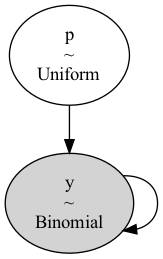

In [11]:
gv = pm.model_graph.model_to_graphviz(model)
display_png(gv)

It's now time to sample from the posterior using PyMC. You'll also then plot the posterior:

In [12]:
with model:
    samples = pm.sample(2000, return_inferencedata=True)
    # We're also sampling the prior/posterior predictives,
    # which we'll introduce and explain below
    idata = pm.sample_prior_predictive(model=model)
    idata.extend(pm.sample(progressbar=False))
    idata.extend(pm.sample_posterior_predictive(idata, progressbar=False))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


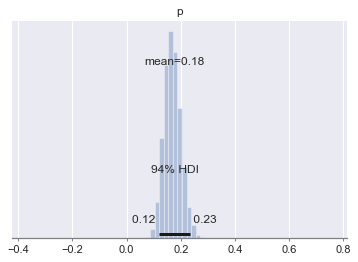

In [13]:
# Posterior samples of $p$, the click-through rate, having seen the data.
with model:
    az.plot_posterior(samples, kind='hist');

#### Predictive checks and traceplots

Let's now introduce 3 diagnostic tools, which will come in handy when building models:

- prior predictive check,
- posterior predictive check, and
- traceplots.

**Prior predictive checks** essentially generate samples of the data
based on your specified priors without looking at the actual data.
They help you check whether your priors are sensible distributions,
or if they have the potential to generate wildly unreasonable data.
Let's plot the prior predictive check ECDF for our model above:

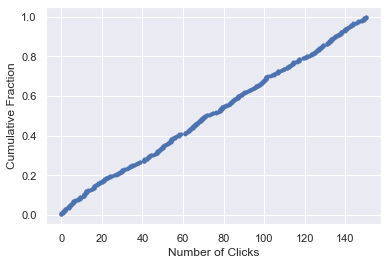

In [14]:
# Prior predictive samples for observed data.
# Generate x & y data for ECDF
x_ecdf, y_ecdf = ecdf(idata.prior_predictive["y"].data.flatten())
# Plot the ECDF
plt.plot(x_ecdf, y_ecdf, marker='.', linestyle='none');
plt.xlabel("Number of Clicks")
plt.ylabel("Cumulative Fraction");

Now, we have to ask the question: Does this prior predictive check look sensible?
This question is both qualitative and quantitative.
Qualitatively, it looks extremely similar to a uniform distribution's CDF.
Quantitatively, its lower bound $0$ and upper bound $150$ are what we expect.
We know that we are sampling the number of click throughs
out of a total number of 150 website landings
so this prior distribution looks pretty good!

Counterfactually, we would be concerned if there negative values _or_ values over $150$,
as they would violate what we assume about our data-generating processes.
In the next example, we'll see how red flags in our prior predictive check
can lead us to alter our priors.

The *posterior* predictive check samples our posterior distribution of data so we would expect it to look something like our actual data. Let's check it out, in this example:

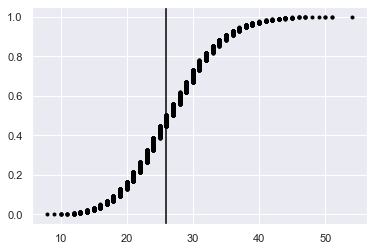

In [15]:
# Generate x & y data for ECDF
x_ecdf, y_ecdf = ecdf(idata.posterior_predictive["y"].data.flatten())
# Plot the ECDF
plt.plot(x_ecdf, y_ecdf, marker='.', linestyle='none', color="black")
plt.axvline(x=n_successes_a, color="black");

Notice that this looks somewhat Gaussian, centered around 21. Now our data is a single number, the number of clicks, so we would expect it to be around $21\pm5$. Let's see what it is:

In [16]:
n_successes_a

26

This looks good.

Finally, let's now plot the *traceplot*, which plots our parameters as a function of iteration number and tells us about whether our sampling has converged. Essentially we want to make sure that the sampling procedure doesn't "shoot off" in any weird way, such as in the following:

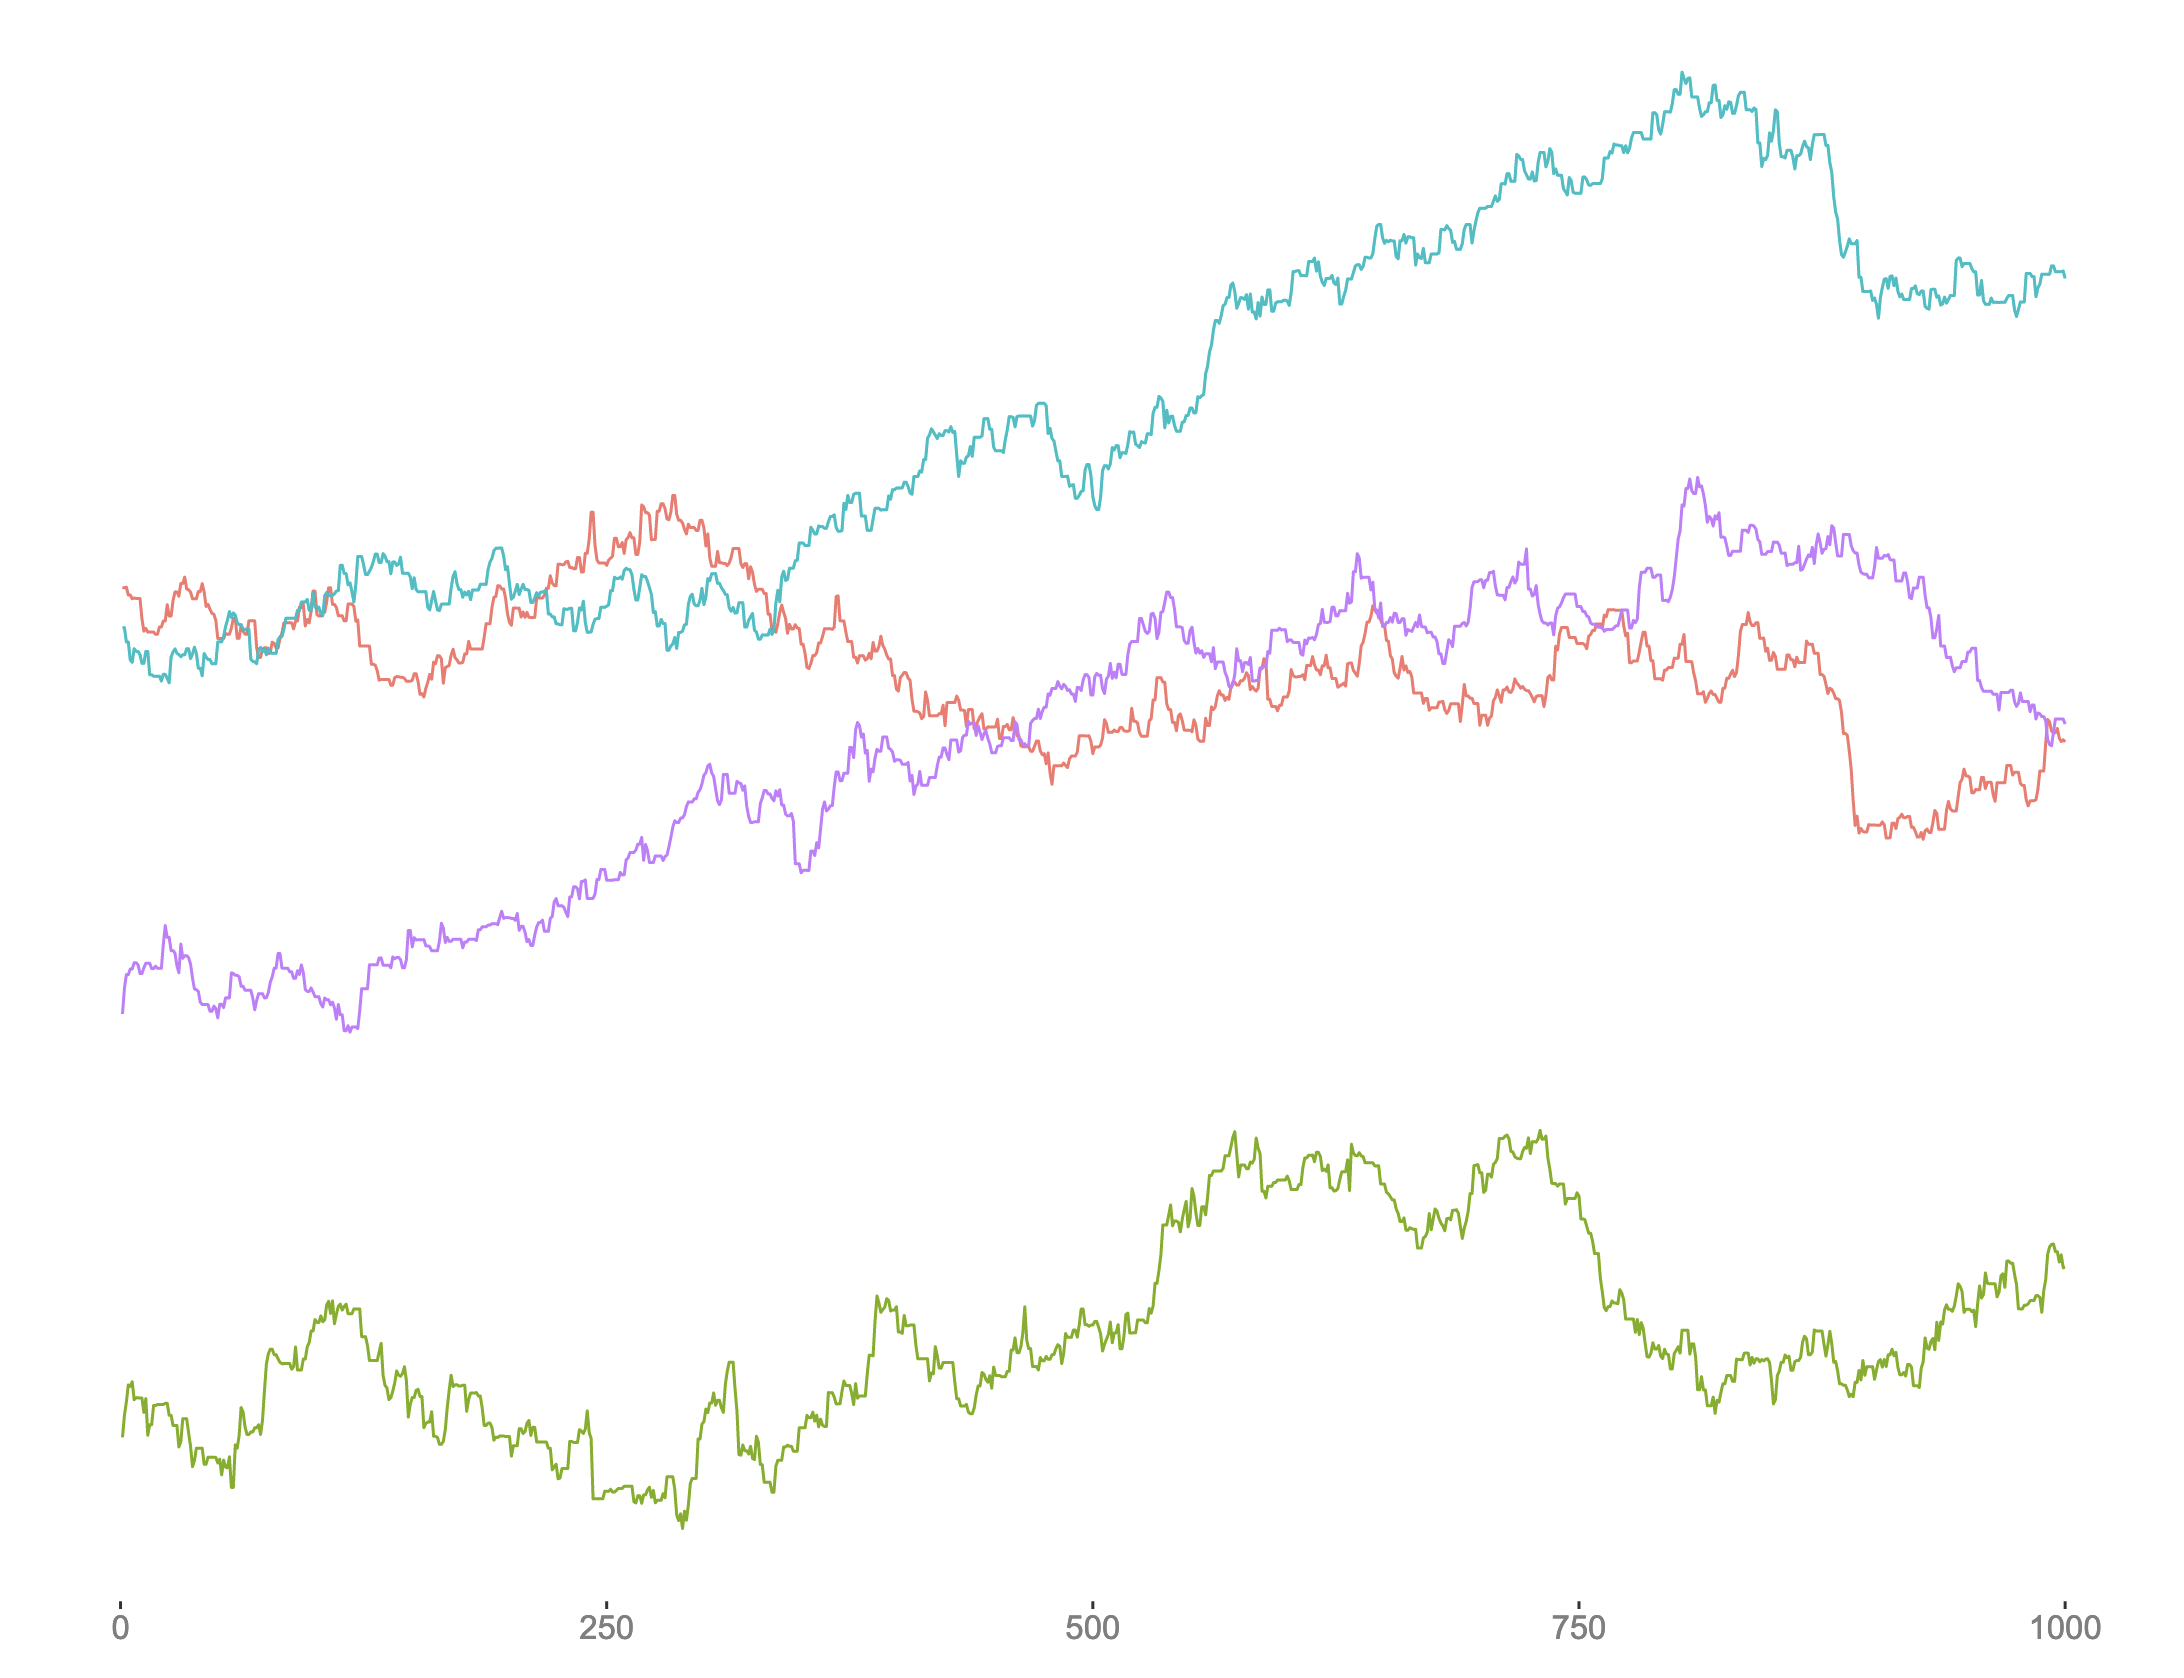

In [17]:
from IPython.display import Image
Image("../../images/badchains.png")

What we really want to see is a traceplot that doesn't exhibit drift but diffusion,
that is, noise around a certain value.
There are ways to frame this in terms of autocorrelation but,
for the time being, the most important way to think about it is
you want to see a traceplot that looks something like a "hairy caterpillar",
which we do on the right in this case
(on the left we have the samples of our distribution):

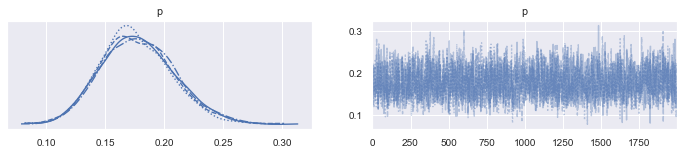

In [18]:
az.plot_trace(samples);

### Parameter estimation II -- the mean of a population

We'll now calculate the  posterior mean beak depth of Galapagos finches in a given species. First let's load the data and subset it with respect to species:

In [19]:
# Import and view head of data
df_12 = pd.read_csv('../../data/finch_beaks_2012.csv')
df_fortis = df_12.loc[df_12['species'] == 'fortis']
df_scandens = df_12.loc[df_12['species'] == 'scandens']

To specify the full probability model, we need
- a likelihood function for the data &
- priors for all unknowns.

What is the likelihood here? Let's plot the measurements below and see that they look approximately normal so we'll use a normal likelihood $y_i\sim \mathcal{N}(\mu, \sigma^2)$. The unknowns here are the mean $\mu$ and standard deviation $\sigma$ and we'll use weakly informative priors on both

- a normal prior for $\mu$ with mean $10$ and standard deviation $5$;
- a lognormal prior for $\sigma$ with $\mu = 0$ and $\sigma = 10$.

There are biological reasons for these priors 
(**NOTE: not really now, with the lognormal prior? 
Need to explain what the biological reasons are otherwise**)
also but we can also test that the posteriors are relatively robust to the choice of prior here due to the amount of data.

/Users/hba/opt/anaconda3/envs/generative-thinking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


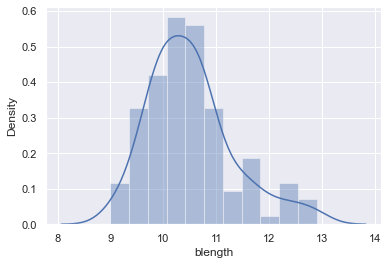

In [20]:
sns.distplot(df_fortis['blength']);

Let's now build our model:

In [21]:
with pm.Model() as model:
    # Prior for mean & standard deviation
    mu_1 = pm.Normal('mu_1', mu=10, sigma=5)
    sigma_1 = pm.Lognormal('sigma_1', 0, 10)
    # Gaussian Likelihood
    y_1 = pm.Normal('y_1', mu=mu_1, sigma=sigma_1,
     observed=df_fortis['blength'])

Once again, we can also visualize our model graph:

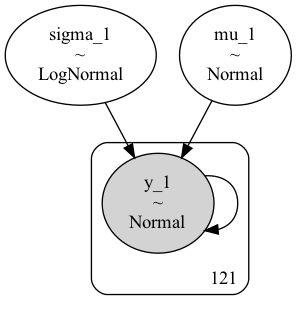

In [22]:
gv = pm.model_graph.model_to_graphviz(model)
display_png(gv)

We now press our inference button and sample from the posterior:

In [23]:
with model:
    samples = pm.sample(2000, return_inferencedata=True)
    idata = pm.sample_prior_predictive(model=model)
    idata.extend(pm.sample(progressbar=False))
    idata.extend(pm.sample_posterior_predictive(idata, progressbar=False))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/hba/opt/anaconda3/envs/generative-thinking/lib/python3.9/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_1, sigma_1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/hba/opt/anaconda3/envs/generative-thinking/lib/python3.9/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_1, sigma_1]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Let's now plot our *prior predictive check*, data, and *posterior predictive check*:

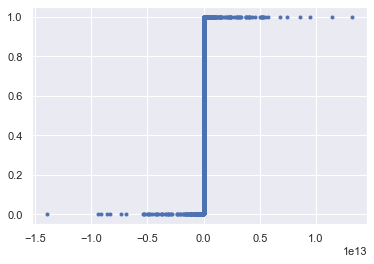

In [24]:
x_ecdf, y_ecdf = ecdf(idata.prior_predictive["y_1"].data.flatten())
# Plot the ECDF
plt.plot(x_ecdf, y_ecdf, marker='.', linestyle='none');

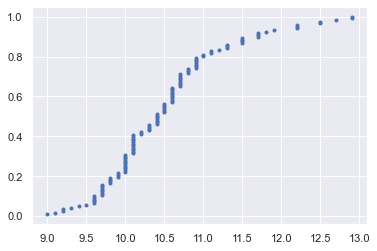

In [25]:
x_ecdf, y_ecdf = ecdf(df_fortis['blength'].values)
# Plot the ECDF
plt.plot(x_ecdf, y_ecdf, marker='.', linestyle='none');

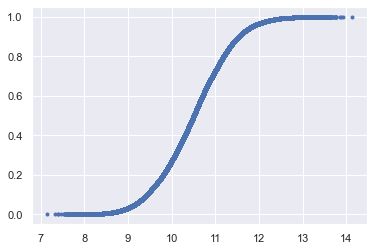

In [26]:
x_ecdf, y_ecdf = ecdf(idata.posterior_predictive["y_1"].data.flatten())
# Plot the ECDF
plt.plot(x_ecdf, y_ecdf, marker='.', linestyle='none');

Although the *posterior predictive check* passes the eyeball test (when comapring with the data), the *prior predictive check* does not! Looking at the x-axis on it, we see that we end up with values orders of magnitude larger than what a beak length could possibly be!

This means that our priors aren't quite right yet.
Looking at them, we can see that having a Lognormal prior for our variance
means that we could end up with some pretty large values
so let's try a prior that drops off more quickly (we say it has a _shorter tail_).
We'll try an Exponential prior here as we know that these have shorter tails.
We don't expect the reader to be aware of this
but we hope to help build your intuition around this here
and in the following case stories!

In [27]:
with pm.Model() as model:
    # Prior for mean & standard deviation
    mu_1 = pm.Normal('mu_1', mu=10, sigma=5)
    sigma_1 = pm.Exponential('sigma_1', lam=0.5)
    # Gaussian Likelihood
    y_1 = pm.Normal('y_1', mu=mu_1, sigma=sigma_1, 
    observed=df_fortis['blength'])

In [28]:
with model:
    samples = pm.sample(2000, return_inferencedata=True)
    idata = pm.sample_prior_predictive(model=model)
    idata.extend(pm.sample(progressbar=False))
    idata.extend(pm.sample_posterior_predictive(idata, 
        progressbar=False))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/hba/opt/anaconda3/envs/generative-thinking/lib/python3.9/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_1, sigma_1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/hba/opt/anaconda3/envs/generative-thinking/lib/python3.9/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_1, sigma_1]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Let's now plot our *prior* and *posterior* predictive checks:

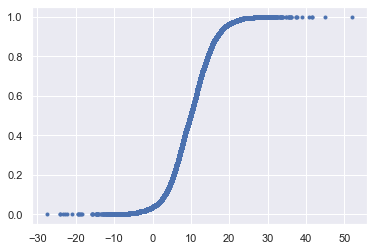

In [29]:
x_ecdf, y_ecdf = ecdf(idata.prior_predictive["y_1"].data.flatten())
# Plot the ECDF
plt.plot(x_ecdf, y_ecdf, marker='.', linestyle='none');

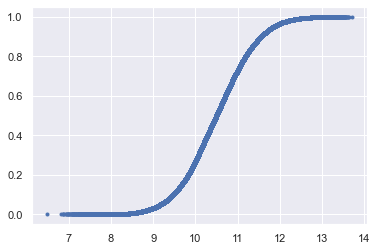

In [30]:
x_ecdf, y_ecdf = ecdf(idata.posterior_predictive["y_1"].data.flatten())
# Plot the ECDF
plt.plot(x_ecdf, y_ecdf, marker='.', linestyle='none');

The *prior* predictive check is now looking a lot better!
There is still the possibility of negative values, so that may still be an issue.
Additionally, if it were still generating data that are too large,
we could increase the exponent `lam`, among other things.

Now let's plot the posteriors of our two parameters, mean $\mu$ and standard deviation $\sigma$:

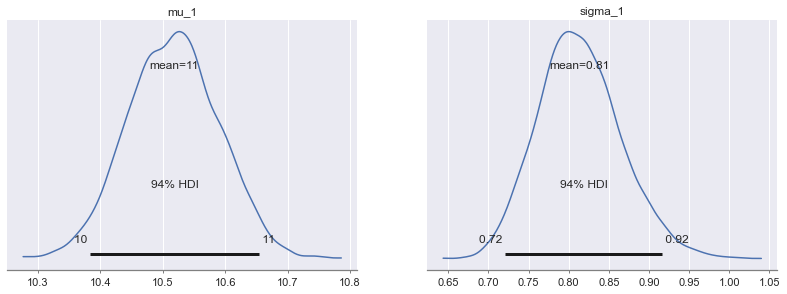

In [31]:
with model:
    az.plot_posterior(samples);

We once again plot the traceplot, which plots our parameters as a function of iteration number, showing that our model has converged:

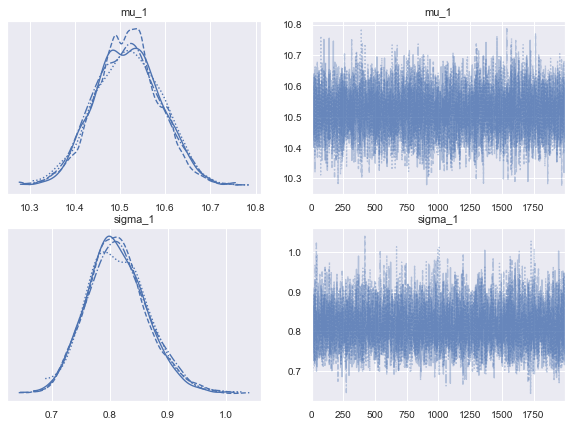

In [32]:
az.plot_trace(samples, figsize=(10, 7));

## Bayesian hypothesis testing

After parameter estimation, a common scientific question involves hypothesis testing, so let's now see how Bayesian inference and probabilistic programming can be used for hypothesis testing.

### Bayesian hypothesis testing I: A/B tests on click through rates

Assume we have a website and want to redesign the layout (*A*) and test whether the new layout (*B*) results in a higher click through rate. When people come to our website we randomly show them layout *A* or *B* and see how many people click through for each. First let's generate the data we need:

In [33]:
# click-through rates
p_a = 0.15
p_b = 0.20
N = 1000
n_successes_a = np.sum(np.random.uniform(size=N) <= p_a)
n_successes_b = np.sum(np.random.uniform(size=N) <= p_b)

Once again, we need to specify our models for $p_a$ and $p_b$. Each will be the same as the CTR example above
- Binomial likelihoods
- uniform priors on $p_a$ and $_p$.

We also want to calculate the posterior of the difference $p_a-p_b$ and we do so using `pm.Deterministic()`, which specifies a deterministic random variable, i.e., one that is completely determined by the values it references, in the case $p_a$ & $p_b$.

We'll now build the model:

In [34]:
with pm.Model() as model:
    # Prior on p
    prob_a = pm.Uniform('p_a')
    prob_b = pm.Uniform('p_b')
    # Binomial Likelihood
    y_a = pm.Binomial('y_a', n=N, p=prob_a, observed=n_successes_a)
    y_b = pm.Binomial('y_b', n=N, p=prob_b, observed=n_successes_b)
    diff_clicks = pm.Deterministic('diff_clicks', prob_a-prob_b)

Let's now plot our model graph:

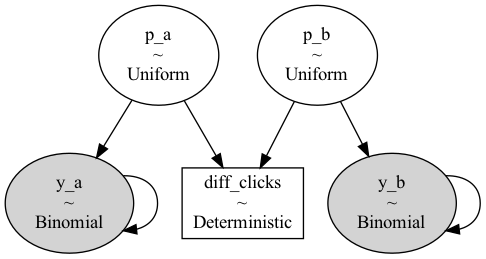

In [35]:
gv = pm.model_graph.model_to_graphviz(model)
display_png(gv)

Sample from the posterior and plot them:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/hba/opt/anaconda3/envs/generative-thinking/lib/python3.9/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_a, p_b]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


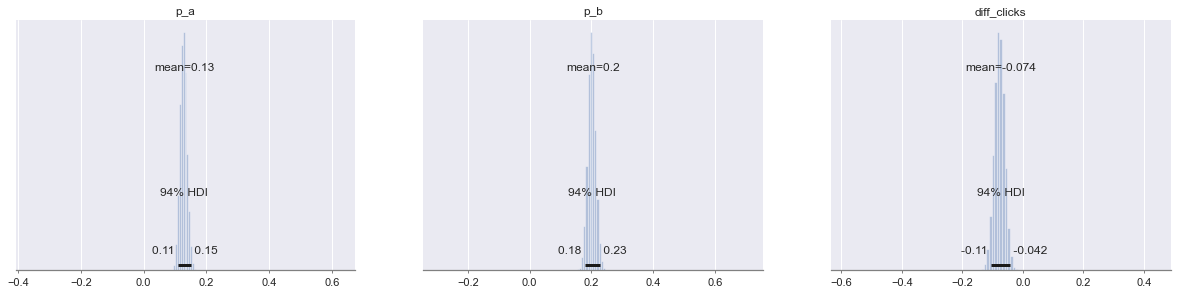

In [36]:
with model:
    samples = pm.sample(2000, return_inferencedata=True)
    az.plot_posterior(samples, kind='hist');

We once again plot the traceplot, which plots our parameters as a function of iteration number, showing that our model has converged:

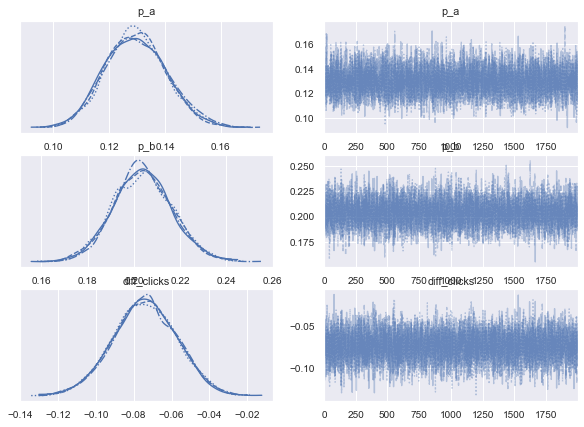

In [37]:
az.plot_trace(samples, figsize=(10, 7));

Note that, for the sake of brevity, we did not perform our predictive checks, but this is something that the excited reader can do, in this case, and for those below!

### Bayesian hypothesis testing II -- beak lengths difference between species

In the following, we seek to determine whether the mean beak length of the Galapagos finches differs between species. For the mean of each species, we use the same model as in previous section:

- Gaussian likelihood;
- Normal prior for the means;
- Uniform prior for the variances.

We also calculate the difference between the means and, the _effect size_, which is the difference between the means divided by the pooled standard deviations = $\sqrt{(\sigma_1^2+\sigma_2^2)/2}$. 

We then sample from the posteriors and plot them!

In [38]:
with pm.Model() as model:
    # Priors for means and variances
    mu_1 = pm.Normal('mu_1', mu=10, sigma=5)
    sigma_1 = pm.Uniform('sigma_1', 0, 10)
    mu_2 = pm.Normal('mu_2', mu=10, sigma=5)
    sigma_2 = pm.Uniform('sigma_2', 0, 10)
    # Gaussian Likelihoods
    y_1 = pm.Normal('y_1', mu=mu_1, sigma=sigma_1, observed=df_fortis['blength'])
    y_2 = pm.Normal('y_2', mu=mu_2, sigma=sigma_2, observed=df_scandens['blength'])
    # Calculate the effect size and its uncertainty.
    diff_means = pm.Deterministic('diff_means', mu_1 - mu_2)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(sigma_1, 2) + 
                                         np.power(sigma_2, 2)) / 2)
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

Let's now plot our model graph:

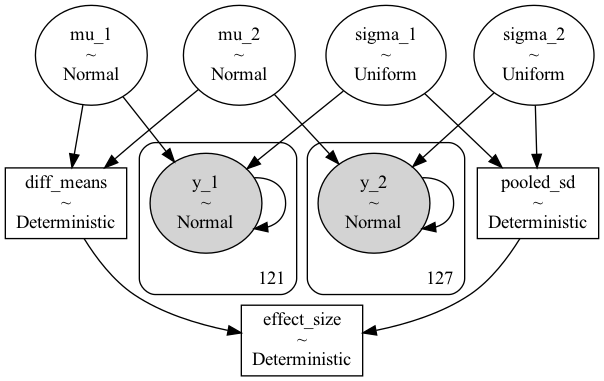

In [39]:
gv = pm.model_graph.model_to_graphviz(model)
display_png(gv)

In [40]:
with model:
    samples = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/hba/opt/anaconda3/envs/generative-thinking/lib/python3.9/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_1, sigma_1, mu_2, sigma_2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


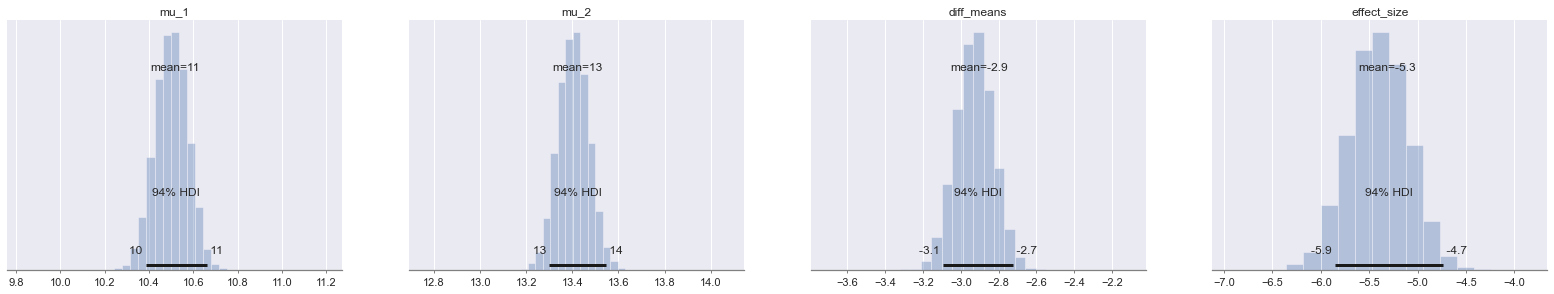

In [41]:
az.plot_posterior(samples, 
    var_names=['mu_1', 'mu_2', 'diff_means', 'effect_size'], kind='hist');

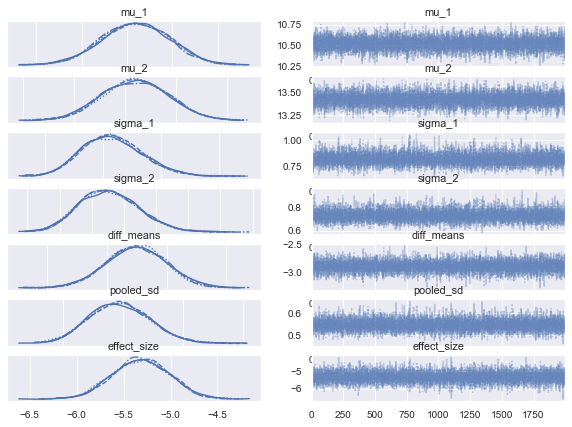

In [42]:
az.plot_trace(samples, figsize=(10, 7));

## Bayesian regression

In the above, we have seen how to use the Bayesian workflow and probabilistic programming for both parameter estimation and comparison between groups. To now round out our first few Bayesian modeling tools, let's see how to use the Bayesian workflow and probabilistic programming for linear regression!

To this end, let's first generate some bivariate data, consisting of a linear relationship and a noise/error term:

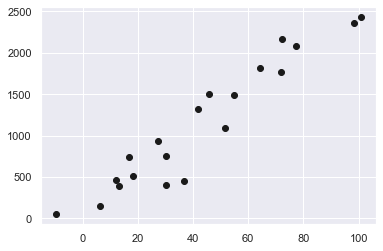

In [43]:
np.random.seed(42)
(m, b) = (25, 0.5)
x = 100 * np.random.random(20)
y = m * x + b

# add scatter to points
x = np.random.normal(x, 10)
y = np.random.normal(y, 10)

plt.plot(x, y, 'ok');


Now recall that our Bayesian model building steps are
1. To completely specify the model in terms of _probability distributions_. This includes specifying 
    - what the form of the sampling distribution of the data is _and_ 
    - what form describes our _uncertainty_ in the unknown parameters.
2. Calculate the _posterior distribution_.

The sampling distribution of the data is given by $y = mx + b + \sigma$, where $m$ is the gradient, $b$ the $y$-intercept, and $\sigma$ the error/noise term. These are the unknown parameters, which we need to describe our _uncertatinty_ around using priors and we choose:

- Gaussian priors for $m$ and $b$,
- A Half-Cauchy prior for $\sigma$ (this is a distribution that has desirable properties for us, but isn't worth getting into the details of)

In [44]:
with pm.Model() as model:
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    b = pm.Normal("b", 0, sigma=20)
    m = pm.Normal("m", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=b + m * x, sigma=sigma, observed=y)

Let's now plot our model graph:

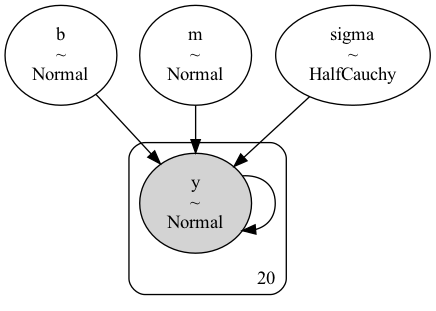

In [45]:
gv = pm.model_graph.model_to_graphviz(model)
display_png(gv)

In [46]:
with model:
    samples = pm.sample(2000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/hba/opt/anaconda3/envs/generative-thinking/lib/python3.9/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, m]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


Let's now plot the traceplot, which plots our parameters as a function of iteration number and here shows that our model has converged in a desirable way:

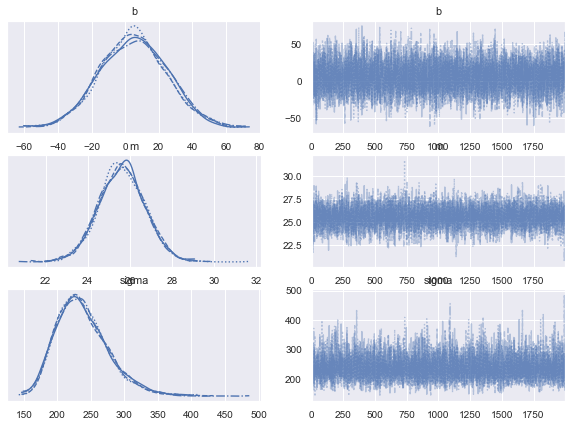

In [47]:
az.plot_trace(samples, figsize=(10, 7));

## Wrapping up

In this notebook, we've introduced the fundamentals of the principled Bayesian workflow and demonstrated its utility in answering the common scientific questions of parameter estimation and hypothesis testing. We've done so for two different types of data, the first an example of data from A/B testing, the second a dataset from basic research of Galapagos finch beak measurements. We also introduced Bayesian linear regression.